In [1]:
import os
import sys
import time

from sklearn.model_selection import train_test_split
import numpy as np

from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, Input
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras.utils import np_utils
from keras.datasets import cifar10
from keras import backend as K
from keras.utils.visualize_util import model_to_dot


from bokeh.plotting import figure, show
from bokeh.io import output_notebook
import matplotlib.pyplot as plt
from IPython.display import display, SVG


%matplotlib inline
output_notebook()

if not os.path.exists('output'):
    os.makedirs('output')

Using TensorFlow backend.


Loading BokehJS ...

In [2]:
def plot_history(his, test_acc):
    l = len(his['val_acc'])
    fig = figure()
    fig.line(range(1,l+1), his['acc'], color='red', legend='train-acc')
    fig.line(range(1,l+1), his['val_acc'], color='blue', legend='valid-acc')
    fig.circle([l], [test_acc], color='blue', size=5, legend='test-acc')
    fig.xaxis.axis_label, fig.yaxis.axis_label = '#epoch', 'accuracy'
    show(fig)
    
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
Y_train, Y_test = np_utils.to_categorical(y_train), np_utils.to_categorical(y_test)
print('[CIFAR-10 loaded]')
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=1337)

[CIFAR-10 loaded]


## Incorporating Prior Knowledge: CNN
For image classification, we know that our target object may appear in any locations of the image. However, if we use fully-connected layers, we'd have to learn that object pattern several times(in different location). Wouldn't it be better if we could **learn that object pattern just once** and **detect objects by scanning through all different locations of images**? This is how CNN(Convolutional Neural Network) is introduced.
<img src="https://drive.google.com/a/datalab.cs.nthu.edu.tw/uc?id=0BxGBu16r86Q0RmVpWHBsNFdwZEE" width="500">
Computation of convolutional layer is still the same as fully-connected layer: $\displaystyle y=\sigma(XW+b)$, but with several difference:
 * local connectivity: to scan through inputs for detecting patterns
   * $W$: the weights of convolution layer is called **filter**, on which a pattern will be learned
     * a filter is usually in 3D(width, height, depth), where we specified width and height, but depth is impliticty defined as \#input channel(why? try to figure out by yourself)
     * $W$ is in 4D(width, height, depth, \#filter)
   * $X$: areas that the filter is scanned on, the size is called **receptive field**($=$ filter size)
     * $X\neq$ layer input: $X$ is obtained by spanning layer input with same size but in different locations, there're 2 hyperparameters:
       * **stride**(downsampling factor): the scanning interval
       * **padding**: add 0 to the border
   * if we use $n$ filters each with size $f\times f$ to scan the layer input of size=$(w,h,c)$, suppose the stride=$s$ and zero-padding $p$, then 
     * $W$ is of size $f\times f\times c\times n$
     * $X$ is of size $\displaystyle (\frac{w-f+2p}{s}+1)\times(\frac{h-f+2p}{s}+1)\times f\times f\times c$
     * output $y$ is of size $=\displaystyle(\frac{w-f+2p}{s}+1)\times(\frac{h-f+2p}{s}+1)\times n$
   * small-quiz: how to make the size(width and height) of output to be the same as input, if we use a 3x3 filter, and stride=1?
     <table>
    <tr><th>no padding<br><img src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif" width="200"></th><th>(O) pad 1<img src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/same_padding_no_strides.gif" width="200"></th></tr>
    </table>
 * pooling: locally connected to summarize the matched result
   * max-pooling: if we'd like to know whether a pattern appear in a region
   * general-pooling: you can also use other operator, ex: mean, min, but max-pooling works better in practice
   * you can get rid of pooling by setting larger stride in convolutional layer

### VGG-Style CNN
VGG-style CNN is composed of convolutional layer and max-pooling layer at shallow layers to extract features, and then fully-connected layers is used to generate prediction.

In [3]:
def VGG_like_v1():
    img_input = Input(shape=(32, 32, 3)) # dim-order: tf
    # block 1
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1', dim_ordering='tf')(img_input)
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2', dim_ordering='tf')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', dim_ordering='tf')(x)
    # block 2
    x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv1', dim_ordering='tf')(x)
    x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv2', dim_ordering='tf')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', dim_ordering='tf')(x)
    # block 3
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv1', dim_ordering='tf')(x)
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv2', dim_ordering='tf')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', dim_ordering='tf')(x)
    # block 4
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block4_conv1', dim_ordering='tf')(x)
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block4_conv2', dim_ordering='tf')(x)
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block4_conv3', dim_ordering='tf')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', dim_ordering='tf')(x)
    # Classification block
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dense(1024, activation='relu', name='fc2')(x)
    x = Dense(10, activation='softmax', name='predictions')(x)
    # create Model
    model = Model(img_input, x)
    return model

In [4]:
mdl_v1 = VGG_like_v1()
mdl_v1.compile(loss='categorical_crossentropy', optimizer=Adam(lr=5e-5), metrics=['accuracy'])

Keras provides several tools for you to check input/output dimension of model, ex:  keras.model.Model.summary() or keras.utils.visualize_util.model_to_dot().

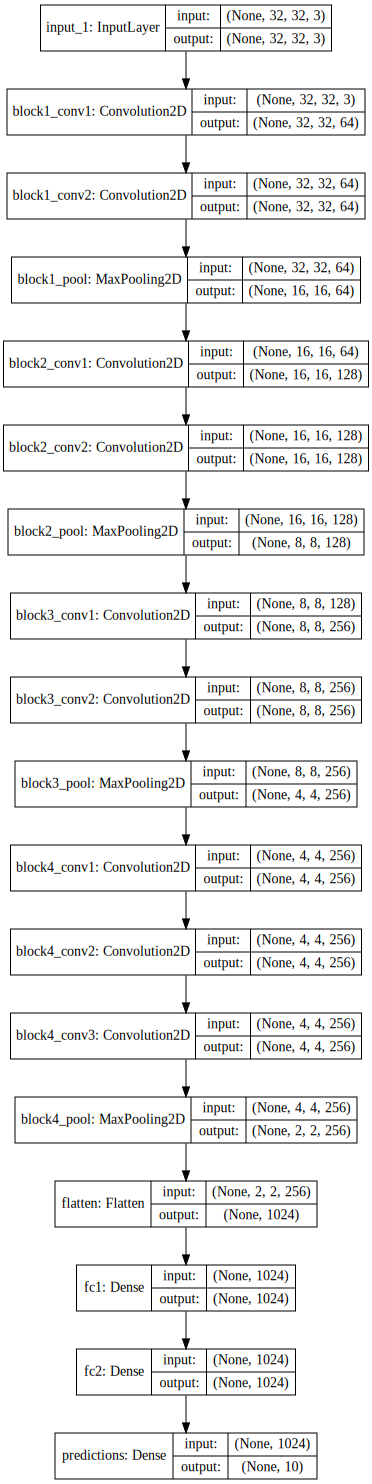

In [5]:
mdl_svg = model_to_dot(mdl_v1, show_shapes=True).create(prog='dot', format='svg')
display(SVG(mdl_svg))

In [6]:
with open('output/VGG_like_v1.svg', 'wb') as f:
    f.write(mdl_svg)

Since we set border of convolutional layers to be the same, you can see the output size only shrink by 2 after max-pooling layers. After passing through 4 max-pooling layers, the 32x32 image is shrinked by a factor of 16, resulting in 256 2x2 feature maps. Then the 2x2x256 feature maps is fed into a dense layer for prediction.

Let's start training our CNN.

In [7]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0)
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, \
                shear_range=0.1, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

We'd like to train the VGG-like network with data augmentation and early stopping.

In [8]:
st = time.time()
v1_his = mdl_v1.fit_generator(datagen.flow(X_train, Y_train, batch_size=128), \
                    samples_per_epoch=X_train.shape[0], nb_epoch=200, validation_data=(X_val, Y_val), \
                    callbacks=[early_stop], verbose=0)
ed = time.time()
test_loss, test_acc = mdl_v1.evaluate(X_test, Y_test, verbose=0)
plot_history(v1_his.history, test_acc)
print('test-acc={:.1f}%, training time {}s'.format(test_acc*100, ed-st))

test-acc=80.0%, training time 830.4971194267273s


We achieve 80% test accuracy, which is much better than our feedforward network model(40%) before. However, from training history, we can clearly observe overfitting.

In [9]:
mdl_v1.save('output/VGG-like-v1.h5')

#### Regularization
All regularization techniques and data augmentation still applies for CNN.

For network architecture, we'd like to
 * add dropout layers to avoid overfitting, with general principle that smaller dropout rate for shallow layers
 * add batch normalization layers to speedup the training

In [10]:
def VGG_like_v2():
    img_input = Input(shape=(32, 32, 3)) # dim-order: tf
    # block 1
    x = Convolution2D(64, 3, 3, activation='linear', border_mode='same', name='block1_conv1', dim_ordering='tf')(img_input)
    x = BatchNormalization(mode=0, axis=3)(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)
    x = Convolution2D(64, 3, 3, activation='linear', border_mode='same', name='block1_conv2', dim_ordering='tf')(x)
    x = BatchNormalization(mode=0, axis=3)(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', dim_ordering='tf')(x)
    # block 2
    x = Convolution2D(128, 3, 3, activation='linear', border_mode='same', name='block2_conv1', dim_ordering='tf')(x)
    x = BatchNormalization(mode=0, axis=3)(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)
    x = Convolution2D(128, 3, 3, activation='linear', border_mode='same', name='block2_conv2', dim_ordering='tf')(x)
    x = BatchNormalization(mode=0, axis=3)(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', dim_ordering='tf')(x)
    # block 3
    x = Convolution2D(256, 3, 3, activation='linear', border_mode='same', name='block3_conv1', dim_ordering='tf')(x)
    x = BatchNormalization(mode=0, axis=3)(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    x = Convolution2D(256, 3, 3, activation='linear', border_mode='same', name='block3_conv2', dim_ordering='tf')(x)
    x = BatchNormalization(mode=0, axis=3)(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', dim_ordering='tf')(x)
    # block 4
    x = Convolution2D(256, 3, 3, activation='linear', border_mode='same', name='block4_conv1', dim_ordering='tf')(x)
    x = BatchNormalization(mode=0, axis=3)(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    x = Convolution2D(256, 3, 3, activation='linear', border_mode='same', name='block4_conv2', dim_ordering='tf')(x)
    x = BatchNormalization(mode=0, axis=3)(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    x = Convolution2D(256, 3, 3, activation='linear', border_mode='same', name='block4_conv3', dim_ordering='tf')(x)
    x = BatchNormalization(mode=0, axis=3)(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', dim_ordering='tf')(x)
    # Classification block
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='linear', name='fc1')(x)
    x = BatchNormalization(mode=1)(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(1024, activation='linear', name='fc2')(x)
    x = BatchNormalization(mode=1)(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(10, activation='softmax', name='predictions')(x)
    # create Model
    model = Model(img_input, x)
    return model

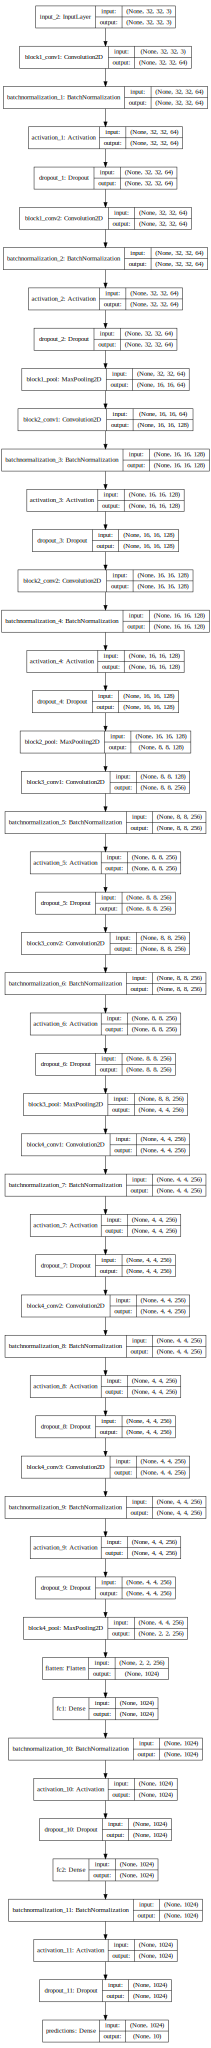

In [11]:
mdl_v2 = VGG_like_v2()
mdl_svg = model_to_dot(mdl_v2, show_shapes=True).create(prog='dot', format='svg')
display(SVG(mdl_svg))
with open('output/VGG_like_v2.svg', 'wb') as f:
    f.write(mdl_svg)

In [12]:
mdl_v2.compile(loss='categorical_crossentropy', optimizer=SGD(momentum=0.9), metrics=['accuracy'])

Although using optimizer like Adam would automatically adjust the learning rate for you, where the learning rate is increased for those those with flat gradient and is decreased for dimensions with sharp gradient. However, Adam is a bad for the convergence of neural networks, since learning rate should be decreased to better approach the local minimum but Adam would do the contrary thing! In the end, we might be shooting up and down over the minimum point. So, this time we'd like to use a better learning rate scheduler by ourself.

In [13]:
fit_seg_num = 5

for i in range(fit_seg_num):
    def lr_scheduler(epoch):
        return 0.01 / 2**i
    # fit the network...

`fit_seg_num` means to fit the network with how many segments, where in each segment the network is trained to converge with a fixed learning rate and then we decrease the learning rate and fit the network in next segment.

In [14]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0)
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, \
                shear_range=0.1, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

Also, we'll train the network with data augmentation and early stopping as above section. Let's train our improved VGG-like network again.

In [15]:
fit_seg_num = 5
hists = {'val_acc':[], 'acc':[]}

st = time.time()
for i in range(fit_seg_num):
    def lr_scheduler(epoch):
        return 0.01 / 2**i
    hist = mdl_v2.fit_generator(datagen.flow(X_train, Y_train, batch_size=128), \
                samples_per_epoch=X_train.shape[0], nb_epoch=200, validation_data=(X_val, Y_val), \
                callbacks=[early_stop, LearningRateScheduler(lr_scheduler)], verbose=0)
    hists['val_acc'] += hist.history['val_acc']
    hists['acc'] += hist.history['acc']
ed = time.time()

test_loss, test_acc = mdl_v2.evaluate(X_test, Y_test, verbose=0)
plot_history(hists, test_acc)
print('test-acc={:.1f}%, training time {}s'.format(test_acc*100, ed-st))
mdl_v2.save('output/VGG_like_v2.h5')

test-acc=90.2%, training time 3532.2658677101135s


After training for 1hr, our regularized version of VGG-like CNN achieves 90% accuracy, great!